In [13]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge


def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: градиент функции f (вектор размерности 2)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array пар вида (x, f(x))
    """
    if x0 is None:
        x0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла -- шаг градиентнго спуска
    curr_x = x0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)
        # не забудьте про lr!
        curr_x -= lr * grad_f(curr_x)

    return np.vstack(history)

def generate_batches(X, y, batch_size):
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    # YOUR CODE with yield
    for i in np.arange(len(X)//batch_size):
        ind = perm[i * batch_size : (i + 1) * batch_size]
        yield (X[ind], y[ind])

def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class MyElasticLogisticRegression(object):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None

    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        n, k = X.shape        
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        # Напоминание:
        # Не добавлен столбец из единиц: X, X_batch
        # Добавлен столбец из единиц: X_train

        losses = [] # Сюда будут записываться значения функционала ошибок.
        
        #### YOUR CODE (train loop here, use self.get_grad)####
        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X, y, batch_size):
                #
                #  Запись текущей ошибки:
                #
                curr_predictions = self.predict_proba(X_batch)  
                curr_loss_batch = self.__loss(y_batch, curr_predictions)
                losses.append(curr_loss_batch)
                #
                #  Шаг градиентного спуска:
                #
                _X_batch = np.concatenate((np.ones((len(X_batch), 1)), X_batch), axis=1)
                self.w -= lr*self.get_grad(_X_batch, y_batch, curr_predictions)
        
        return losses

    def get_grad(self, X_batch, y_batch, predictions):
        """
        Принимает на вход X_batch с уже добавленной колонкой единиц. 
        """
        
        # Градиент основной части функционала по заданному подмножеству данных:
        grad_main = (predictions - y_batch) @ X_batch
        # Градиент регуляризирующей части функционала:
        grad_reg = self.l1_coef * np.sign(self.w) + 2 * self.l2_coef * self.w  
        grad_reg[0] = 0  # Регуляризация касается именно ВЕСОВ при ПРИЗНАКАХ !
        grad = grad_main/len(y_batch) + grad_reg
        
        return grad

    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def get_weights(self):
        return self.w

    def __loss(self, y, p):  
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))


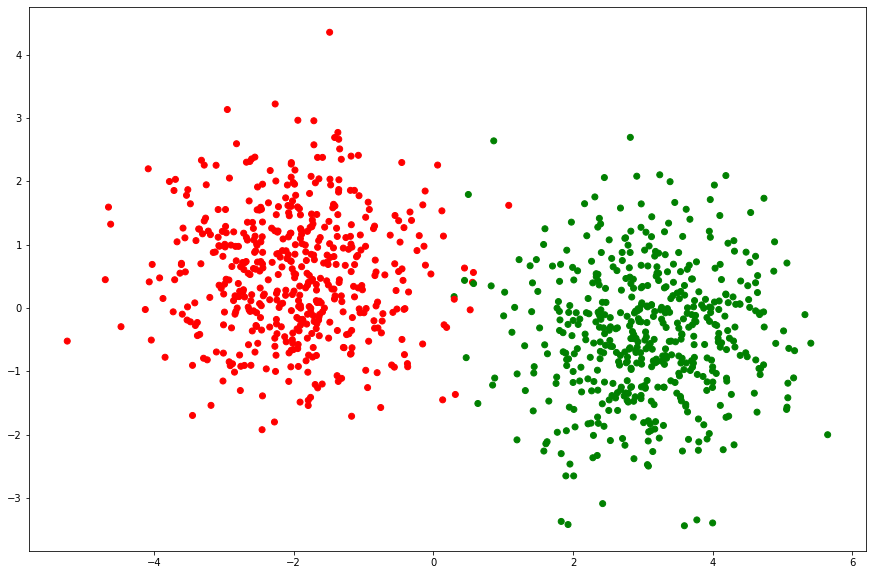

In [14]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)
#y = y.reshape(-1, 1)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [15]:
clf = MyElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

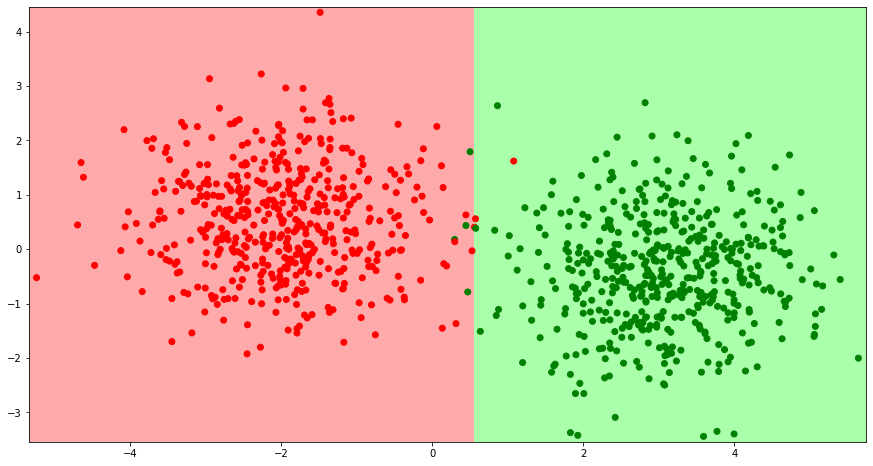

In [16]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)